
Given the challenges in acquiring medical images, we will select 100 images for each class. We will then train the same model in a supervised manner using the dataset consisting of these 100 images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# All imports here:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pathlib
import os
import time, datetime

from random import sample

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

#from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import Model


from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential


In [ ]:
import os
# Define the folders where the images are
dataset= '/content/drive/MyDrive/images_100'
folders_100 = os.listdir(dataset)

In [ ]:


# list to load images and labels
X_train_paper = []
y_train_paper = []
# Funtion to load images and labels
def load_data(folder, label):
    for file_i in os.listdir(folder):
        path = os.path.join(folder, file_i)
        image = cv2.imread(path)

        if image is not None:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB Convertir de BGR a RGB
          image = cv2.resize(image, (224, 224))  # Resize to the same size
          X_train_paper.append(image)
          y_train_paper.append(label)
        else:
          print(path)
# load data to each folder


for  label in folders_100:
  folder = os.path.join(dataset, label)

  load_data(folder=folder, label=label)

In [ ]:
# variables
img_height = 224
img_width =224
depth = 3
BATCH_SIZE = 32
classes=len(folders_100)
labels = folders_100
inputsize = (img_height, img_width, depth)

In [ ]:
X = np.array(X_train_paper)
y = np.array(y_train_paper)

print("Forma del array de imágenes:", X.shape)
print("Forma del array de etiquetas:", y.shape)


Forma del array de imágenes: (600, 224, 224, 3)
Forma del array de etiquetas: (600,)


In [ ]:

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                    shuffle=True, stratify=y ,random_state=42)


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(480, 224, 224, 3)
(480,)
(120, 224, 224, 3)
(120,)


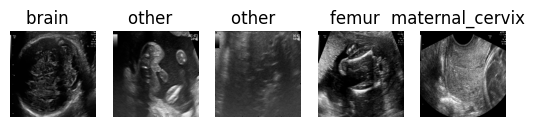

In [ ]:
indices_aleatorios = sample(range(len(x_train)), 5)
for i, idx in enumerate(indices_aleatorios):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx])
    plt.title(f'{y_train[idx]}  ')
    plt.axis('off')

plt.show()

#Check de imagenes y etiquetas

In [ ]:
# Convierte a one-hot encoding
label_encoder = LabelEncoder()

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

y_train_encoded = label_encoder.fit_transform(y_train)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=6)

# Convierte las etiquetas a números
y_val_encoded = label_encoder.fit_transform(y_val)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=6)
# Normalize the pixel values 
x_train = x_train.astype("float") / 255.0
x_val = x_val.astype("float") / 255.0


(480, 224, 224, 3)
(480,)
(120, 224, 224, 3)
(120,)


In [ ]:

datagen = ImageDataGenerator(
    rotation_range=15, # grados de rotacion aleatoria
    width_shift_range=0.3, # fraccion del total (1) para mover la imagen
    height_shift_range=0.3, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    shear_range=0.25, # deslizamiento
    zoom_range=0.2, # rango de zoom
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.3, # cambios aleatorios en los canales de la imagen
     validation_split=0.2 # no va a afectar a validación solo entrenamiento
)

In [ ]:

# documentacion https://keras.io/applications/

base_model = VGG16(weights='imagenet', include_top=False, input_shape=inputsize)

base_model.summary()

# The layers of the first 4 convolutional blocks are frozen, while the fifth one is retrained.
# We have the information about the layer names in base_model.layers.name.
for layer in base_model.layers:
  if layer.name == 'block5_conv3':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

# The last layer of the model is taken, and our classifier (top_model) is added to it.
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(6, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)


# Compilae the model
optimizer = Adam(lr=0.00005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Capa input_3 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Capa block4_conv1 congelada...
Capa block4_conv2 congelada...
Capa block4_conv3 congelada...
Capa block4_pool congelada...
Capa block5_conv1 congelada...
Capa block5_conv2 congelada...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
   

In [ ]:
PATH_TO_SAVE_VGG16= '/content/drive/MyDrive/Colab Notebooks/TFM/results_VGG_100images'

log_dir = PATH_TO_SAVE_VGG16+ "/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


lr_reduce = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.6, patience=8, verbose=1, mode='min', min_lr=5e-5)

checkpoint_filepath = PATH_TO_SAVE_VGG16+"/"+"{epoch:03d}_weights-improvement.h5" #pathout+"/model_checkpoint.h5" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, lr_reduce]

In [ ]:

print("[INFO]: Entrenando la red...")
H = model.fit(datagen.flow(x_train, y_train_one_hot, batch_size=32,
         subset='training'), # the split has been done, indicate it
         validation_data=datagen.flow(x_val, y_val_one_hot,
         batch_size=32, subset='validation'),
          epochs=10, callbacks=[tensorboard_callback, callbacks_list])

plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('epochs')
plt.legend(['Entrenamiento', 'val'], loc='upper left')
plt.savefig(PATH_TO_SAVE_VGG16+"/accuracy.png")

plt.figure()



Test the model of the rest of the images, selecting an epoch where there is not overfitting

In [ ]:

dataset=  '/content/drive/MyDrive/real_images'
folders = os.listdir(dataset)

# list to load images and labels
X_test_paper = []
y_test_paper = []
# Funtion to load images and labels
def load_data(folder, label):
    for file_i in os.listdir(folder):
        path = os.path.join(folder, file_i)
        image = cv2.imread(path)

        if image is not None:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB Convertir de BGR a RGB
          image = cv2.resize(image, (224, 224))  # Resize to the same size
          X_test_paper.append(image)
          y_test_paper.append(label)
        else:
          print(path)
# load data to each folder

for  label in folders:
  folder = os.path.join(dataset, label)

  load_data(folder=folder, label=label)
  print(f"{label}----{folder}")


In [ ]:
X_test_paper = np.array(X_test_paper)
y_test_paper = np.array(y_test_paper)
print("Forma del array de imágenes para test:", X_test_paper.shape)
print("Forma del array de etiquetas para test:", y_test_paper.shape)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test_paper)
y_test_one_hot_p = to_categorical(y_test_encoded, num_classes=7)
print(X_test_paper.shape)
print(y_test_paper.shape)


Forma del array de imágenes para test: (11800, 224, 224, 3)
Forma del array de etiquetas para test: (11800,)
(11800, 224, 224, 3)
(11800,)


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TFM/results_VGG_100images/013_weights-improvement.h5')

In [ ]:

print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_test_paper, batch_size=32)



[INFO]: Evaluando red neuronal...
369/369 [==============================] - 15s 40ms/step


In [ ]:
labels = ['adbomen', 'brain', 'femur', 'maternal_cervix', 'other', 'torax']
print(classification_report(y_test_one_hot_p.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

                 precision    recall  f1-score   support

        adbomen       0.20      0.19      0.20       611
          brain       0.67      0.45      0.54      2992
          femur       0.14      0.52      0.21       940
maternal_cervix       0.65      0.31      0.42      1526
          other       0.51      0.46      0.49      4113
          torax       0.20      0.14      0.17      1618

       accuracy                           0.39     11800
      macro avg       0.40      0.35      0.34     11800
   weighted avg       0.48      0.39      0.41     11800




Select the model finetuned with Google images and finetuned again with 100 images from each class of well labeled dataset

In [ ]:

# load model:
base_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/vgg16/088_weights-improvement.h5')

# Check its architecture
base_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
base_model.trainable=False
inputs = tf.keras.Input(inputsize)
x = base_model(inputs, training=False)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)

x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# The layers of the first 4 convolutional blocks are frozen, while the fifth one is retrained.
# We have the information about the layer names in base_model.layers.name.
for layer in base_model.layers:
  if layer.name == 'block5_conv3':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')
x = base_model.output
# take the last layer os the model and add the lasst layer to the classifier (top_model)
last = base_model.layers[-1].output

x = Flatten()(x)

x = Dense(256, activation='relu', name='fc12')(x)
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu', name='fc22')(x)

x = Dense(6, activation='softmax', name='predictions2')(x)
model = Model(base_model.input, x)


# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[ "categorical_accuracy"])


model.summary()

Capa input_5 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Capa block4_conv1 congelada...
Capa block4_conv2 congelada...
Capa block4_conv3 congelada...
Capa block4_pool congelada...
Capa block5_conv1 congelada...
Capa block5_conv2 congelada...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
     

In [ ]:
PATH_TO_SAVE_VGG16= '/content/drive/MyDrive/Colab Notebooks/TFM/results_VGG_100images-google2'

log_dir = PATH_TO_SAVE_VGG16+ "/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


lr_reduce = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.6, patience=8, verbose=1, mode='min', min_lr=5e-5)

checkpoint_filepath = PATH_TO_SAVE_VGG16+"/"+"{epoch:03d}_weights-improvement.h5" #pathout+"/model_checkpoint.h5" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, lr_reduce]#, early_stop]

[INFO]: Entrenando la red...
Epoch 1/35
3/3 [==============================] - ETA: 0s - loss: 1.7413 - categorical_accuracy: 0.3724
Epoch 1: loss improved from inf to 1.74132, saving model to /content/drive/MyDrive/Colab Notebooks/TFM/results_VGG_100images-google2/001_weights-improvement.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 18s 2s/step - loss: 1.7413 - categorical_accuracy: 0.3724 - val_loss: 1.6888 - val_categorical_accuracy: 0.4167 - lr: 0.0010
Epoch 2/35
3/3 [==============================] - ETA: 0s - loss: 1.5452 - categorical_accuracy: 0.6380
Epoch 2: loss improved from 1.74132 to 1.54524, saving model to /content/drive/MyDrive/Colab Notebooks/TFM/results_VGG_100images-google2/002_weights-improvement.h5
3/3 [==============================] - 6s 2s/step - loss: 1.5452 - categorical_accuracy: 0.6380 - val_loss: 1.5250 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 3/35
3/3 [==============================] - ETA: 0s - loss: 1.3283 - categorical_accuracy: 0.7188
Epoch 3: loss improved from 1.54524 to 1.32834, saving model to /content/drive/MyDrive/Colab Notebooks/TFM/results_VGG_100images-google2/003_weights-improvement.h5
3/3 [==============================] - 7s 3s/step - loss: 1.3283 - categorical_accuracy: 0.7188 - val_loss: 1.2539 - val_categorical_accu

<Figure size 640x480 with 0 Axes>

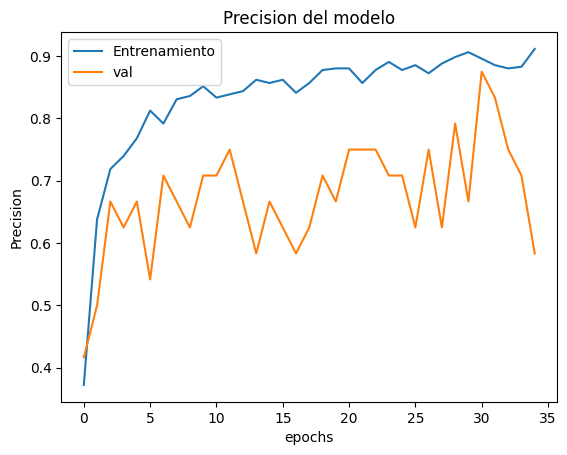

<Figure size 640x480 with 0 Axes>

In [ ]:
print("[INFO]: Entrenando la red...")
H = model.fit(datagen.flow(x_train, y_train_one_hot, batch_size=128,
         subset='training'), 
         validation_data=datagen.flow(x_val, y_val_one_hot,
         batch_size=128, subset='validation'),
          epochs=35, callbacks=[tensorboard_callback, callbacks_list])

plt.plot(H.history['categorical_accuracy'])
plt.plot(H.history['val_categorical_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('epochs')
plt.legend(['Entrenamiento', 'val'], loc='upper left')
plt.savefig(PATH_TO_SAVE_VGG16+"/accuracy.png")

plt.figure()

In [ ]:
model.save('/content/drive/MyDrive/google-random.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TFM/results_VGG_100images-google/google-finetuned-best.h5')

In [ ]:
print("[INFO]: Evaluando red neuronal...")
predictions = model.predict(X_test_paper, batch_size=64)

[INFO]: Evaluando red neuronal...
185/185 [==============================] - 16s 68ms/step


In [ ]:
labels = ['adbomen', 'brain', 'femur', 'maternal_cervix', 'other', 'torax']
print(classification_report(y_test_one_hot_p.argmax(axis=1), predictions.argmax(axis=1), target_names=labels))

                 precision    recall  f1-score   support

        adbomen       0.59      0.83      0.69       611
          brain       0.98      0.96      0.97      2992
          femur       0.72      0.91      0.80       940
maternal_cervix       0.99      1.00      0.99      1526
          other       0.94      0.60      0.73      4113
          torax       0.56      0.93      0.70      1618

       accuracy                           0.82     11800
      macro avg       0.80      0.87      0.82     11800
   weighted avg       0.87      0.82      0.83     11800

